In [2]:
import sys
sys.path.append("../data-science-from-scratch")

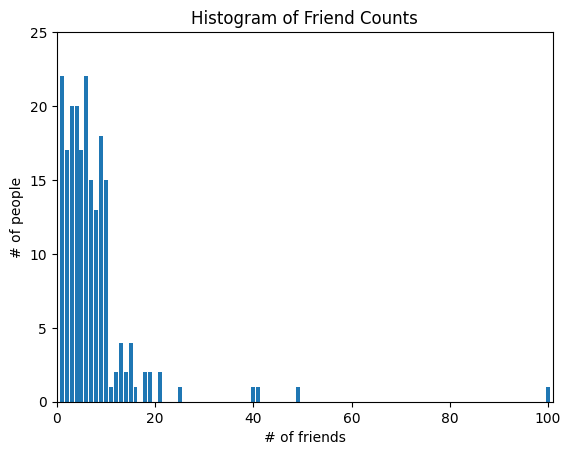

In [3]:
def predict(alpha: float, beta: float, x_i: float) -> float:
    return beta * x_i + alpha


def error(alpha: float, beta: float, x_i: float, y_i: float) -> float:
    return predict(alpha, beta, x_i) - y_i


from scratch.linear_algebra import Vector

def sum_of_sqerrors(alpha: float, beta: float, x: Vector, y: Vector) -> float:
    return sum(error(alpha, beta, x_i, y_i) ** 2
               for x_i, y_i in zip(x, y))


from typing import Tuple
from scratch.linear_algebra import Vector
from scratch.statistics import correlation, standard_deviation, mean


def least_squares_fit(x: Vector, y: Vector) -> Tuple[float, float]:
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta


# Example data
x = [i for i in range(-100, 110, 10)]
y = [3 * i - 5 for i in x]

assert least_squares_fit(x, y) == (-5, 3) 

from scratch.statistics import num_friends_good,daily_minutes_good

alpha,beta = least_squares_fit(num_friends_good,daily_minutes_good)
assert 22.9 < alpha < 23.0
assert 0.9 < beta < 0.905

def mean(data: list[float]) -> float:
    return sum(data) / len(data)

def de_mean(data: list[float]) -> list[float]:
    x_bar = mean(data)
    return [x_i - x_bar for x_i in data]

# from scratch import de_mean 
def total_sum_of_squares(y: Vector) -> float:
    return sum(v**2 for v in de_mean(y))
def r_squared(alpha: float, beta: float, x: Vector , y: Vector) -> float:
    return 1.0 - (sum_of_sqerrors(alpha,beta,x,y)/total_sum_of_squares(y))
rsq = r_squared(alpha,beta,num_friends_good,daily_minutes_good)
assert 0.328 < rsq < 0.330


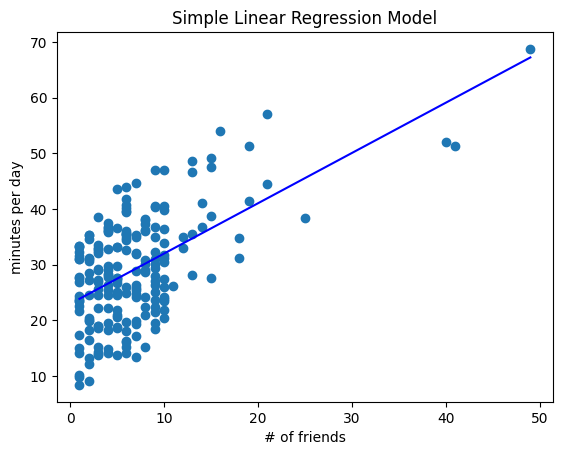

In [6]:
import matplotlib.pyplot as plt

# These variables come from your previous code
# from scratch.statistics import num_friends_good, daily_minutes_good
# alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)

# 1. Create the scatter plot of the actual data points
plt.scatter(num_friends_good, daily_minutes_good)

# 2. Create the regression line
# We need y-values for the line, which are the *predicted* minutes
predicted_minutes = [predict(alpha, beta, x_i) for x_i in num_friends_good]
plt.plot(num_friends_good, predicted_minutes, color='blue') # The blue line

# 3. Add labels and a title to the graph
plt.title("Simple Linear Regression Model")
plt.xlabel("# of friends")
plt.ylabel("minutes per day")

# 4. Display the graph
plt.show()

In [27]:
import random
import tqdm
from scratch.gradient_descent import gradient_step

num_epochs = 10000
random.seed(0)

# Choose random value to start
guess = [random.random(), random.random()]

learning_rate = 0.00001

with tqdm.trange(num_epochs) as t:
    for _ in t:
        alpha, beta = guess

        # Partial derivative of loss with respect to alpha
        grad_a = sum(2*error(alpha,beta,x_i,y_i)
                     for x_i,y_i in zip(num_friends_good,
                                        daily_minutes_good))
        # Partial derivative of loss with respect to beta
        grad_b = sum(2*error(alpha,beta,x_i,y_i) * x_i
                     for x_i,y_i in zip(num_friends_good,
                                        daily_minutes_good))
        
        # Compute loss to stick in the tqdm description
        loss = sum_of_sqerrors(alpha,beta,
                               num_friends_good,daily_minutes_good)
        t.set_description(f"loss: {loss:.3f}")

        # Finally, update the guess
        guess = gradient_step(guess,[grad_a,grad_b], -learning_rate)

# We should get pretty much the same results:
alpha , beta = guess
assert 22.9 < alpha < 23.0
assert 0.9 < beta < 0.905       

# The loop has finished, and 'guess' holds the final values
alpha, beta = guess

print("\n--- Calculation Complete ---")
print(f"Final Alpha (intercept): {alpha}")
print(f"Final Beta (slope): {beta}")

# The assert statements will still run silently if they pass
assert 22.9 < alpha < 23.0
assert 0.9 < beta < 0.905

print("\nAssertion checks passed successfully! ✅")
        

loss: 13196.619: 100%|██████████| 10000/10000 [00:09<00:00, 1079.48it/s]



--- Calculation Complete ---
Final Alpha (intercept): 22.947552155340915
Final Beta (slope): 0.9038659662765034

Assertion checks passed successfully! ✅


loss: 27929.49: 100%|██████████| 3000/3000 [00:02<00:00, 1336.32it/s]


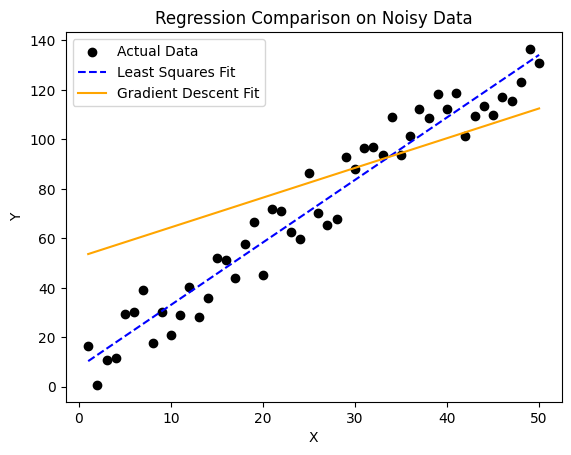

In [ ]:
# Compare Least Squares vs Gradient Descent on Noisy Data

import random
import matplotlib.pyplot as plt
import tqdm

# 1. Create noisy synthetic data
random.seed(42)
x_data = [i for i in range(1, 51)]
y_data = [2.5 * x + 10 + random.uniform(-15, 15) for x in x_data]

# 2. Define helper functions
def predict(alpha: float, beta: float, x_i: float) -> float:
    return beta * x_i + alpha

def error(alpha: float, beta: float, x_i: float, y_i: float) -> float:
    return predict(alpha, beta, x_i) - y_i

def mean(data: list[float]) -> float:
    return sum(data) / len(data)

def de_mean(data: list[float]) -> list[float]:
    x_bar = mean(data)
    return [x_i - x_bar for x_i in data]

def standard_deviation(data: list[float]) -> float:
    n = len(data)
    return (sum((x - mean(data))**2 for x in data) / (n - 1)) ** 0.5

def correlation(x: list[float], y: list[float]) -> float:
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return sum((x_i - mean(x)) * (y_i - mean(y)) for x_i, y_i in zip(x, y)) / ((len(x) - 1) * stdev_x * stdev_y)
    else:
        return 0

def least_squares_fit(x: list[float], y: list[float]) -> tuple[float, float]:
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta

def sum_of_sqerrors(alpha, beta, x, y):
    return sum((predict(alpha, beta, x_i) - y_i)**2 for x_i, y_i in zip(x, y))

def gradient_step(v, gradient, step_size):
    return [v_i + step_size * grad_i for v_i, grad_i in zip(v, gradient)]

# 3. Least squares solution
alpha_ls, beta_ls = least_squares_fit(x_data, y_data)
predicted_ls = [predict(alpha_ls, beta_ls, x) for x in x_data]

# 4. Gradient descent solution
guess = [100.0, -5.0]  # bad initial guess to exaggerate difference
learning_rate = 0.00001
num_epochs = 3000

with tqdm.trange(num_epochs) as t:
    for _ in t:
        alpha, beta = guess
        grad_a = sum(2 * error(alpha, beta, x_i, y_i) for x_i, y_i in zip(x_data, y_data))
        grad_b = sum(2 * error(alpha, beta, x_i, y_i) * x_i for x_i, y_i in zip(x_data, y_data))
        loss = sum_of_sqerrors(alpha, beta, x_data, y_data)
        t.set_description(f"loss: {loss:.2f}")
        guess = gradient_step(guess, [grad_a, grad_b], -learning_rate)

alpha_gd, beta_gd = guess
predicted_gd = [predict(alpha_gd, beta_gd, x) for x in x_data]

# 5. Plot comparison
plt.scatter(x_data, y_data, label="Actual Data", color='black')
plt.plot(x_data, predicted_ls, label="Least Squares Fit", linestyle='--', color='blue')
plt.plot(x_data, predicted_gd, label="Gradient Descent Fit", linestyle='-', color='orange')

plt.title("Regression Comparison on Noisy Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()